# Import Libraries

In [2]:
import os
import torch
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import our custom modules
from model_utils import (
    update_dropout_rates,
    extract_dropout_rates,
    extract_feature_maps,
    replace_dropout_layers,
    add_dropout_layers,
    calc_CoV,
    CatchFeatureMap
)
from baseline_dropouts import ConstantDropout, ScheduledDropout
from adaptive_dropout import AdaptiveInformationDropout, OptimizerConfig
from evaluation_metrics import PredictivePowerMetrics, UncertaintyMetrics

# Define Simple NN

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 1),
        )
        
    def forward(self, x):
        return self.layers(x)

def train(model, x_train, y_train, epochs=1000, verbose=0):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if verbose and (epoch+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
            
    print('-------------------------------------')
    print('Training Complete')
    print('-------------------------------------')
    return model

# Define Data Generation Functions

In [4]:
def generate_synthetic_data(N_train=100, N_test=100):
    x_train = np.linspace(-3, 3, N_train)
    x_test = np.linspace(-3, 3, N_test)
    y_test = np.sin(x_test)  # True function without noise
    return x_train, x_test, y_test

def add_gaussian_noise(x_train, noise_level=0.1):
    noise = np.random.normal(0, noise_level, x_train.shape[0])
    y_train = np.sin(x_train) + noise
    return y_train

# Define Mutual Information-based Loss Function

In [5]:
def calc_mutual_information(x, y, bins=32):
    """Calculate mutual information between input and activation tensors."""
    x_np = x.detach().cpu().numpy().flatten()
    y_np = y.detach().cpu().numpy()
    
    mi_list = []
    for i in range(y_np.shape[1]):
        y_feature = y_np[:, i]
        joint_hist, x_edges, y_edges = np.histogram2d(x_np, y_feature, bins=bins)
        joint_prob = joint_hist / np.sum(joint_hist)
        
        x_marginal = np.sum(joint_prob, axis=1)
        y_marginal = np.sum(joint_prob, axis=0)
        
        non_zero = joint_prob > 0
        mi = np.sum(joint_prob[non_zero] * 
                   np.log(joint_prob[non_zero] / 
                         (x_marginal[:, None] * y_marginal[None, :])[non_zero]))
        mi_list.append(mi)
    
    return np.mean(mi_list) if mi_list else 0

def calc_information_loss(pre_dropout, post_dropout, properties={}):
    """Calculate information loss between pre and post dropout states."""
    input_instance = properties.get('input_instance')
    mi_score_full_model = properties.get('mi_score_full_model')
    
    mi_score = calc_mutual_information(x=input_instance, y=post_dropout)
    information_loss = np.abs((mi_score - mi_score_full_model)) / mi_score_full_model
    
    return torch.tensor(information_loss)

# Experiment Configuration

In [6]:
# Reproducibility
SEED = 123

# Data Generation
noise_level = 0.1
N_train = 100
N_test = 100
epochs = 1000

# Dropout Configurations
constant_dropout_rate = 0.10
dropout_layers_placement = ['layers.0', 'layers.2']

# Rate-In Configuration
information_loss_threshold = constant_dropout_rate
optimizer_params = OptimizerConfig(
    max_iterations=100,
    learning_rate = 0.10,
    decay_rate = 0.9,
    stopping_error=0.01
)
verbose_rate_in = 0

# Monte-Carlo Simulations
MC_iters = 100

# Evaluation metric
mse_func = PredictivePowerMetrics.mse

# Model Training and Evaluation

In [7]:
# Set random seeds
np.random.seed(SEED)
torch.manual_seed(SEED)

# Generate data
x_train, x_test, y_test = generate_synthetic_data(N_train, N_test)
y_train = add_gaussian_noise(x_train, noise_level)

# Convert to tensors
x_train_tensor = torch.from_numpy(x_train).float().unsqueeze(1)
x_test_tensor = torch.from_numpy(x_test).float().unsqueeze(1)
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Train base model
model_full = Net()
print(model_full)
model_full = train(model=model_full, x_train=x_train_tensor, y_train=y_train_tensor, 
             epochs=epochs, verbose=1)

y_pred = model_full(x_test_tensor)
print(f"Base model MSE: {mse_func(y_pred, y_test_tensor)}")

Net(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
Epoch [200/1000], Loss: 0.0108
Epoch [400/1000], Loss: 0.0098
Epoch [600/1000], Loss: 0.0097
Epoch [800/1000], Loss: 0.0098
Epoch [1000/1000], Loss: 0.0089
-------------------------------------
Training Complete
-------------------------------------
Base model MSE: 0.003352251136675477


# Inference Time MC-Dropout

##### Add constant dropout layers

In [8]:
# Add constant dropout layers
model_constant = add_dropout_layers(
    model=copy.deepcopy(model_full),
    dropoutLayer=torch.nn.Dropout(p=constant_dropout_rate),
    placement_layers=dropout_layers_placement
)
print(model_constant)

y_pred = model_constant(x_test_tensor)
print(f"Constant dropout MSE: {mse_func(y_pred, y_test_tensor)}")

Net(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): Dropout(p=0.1, inplace=False)
    )
    (1): ReLU()
    (2): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Dropout(p=0.1, inplace=False)
    )
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
Constant dropout MSE: 0.07694017142057419


##### Add adaptive Rate-In dropout layers

In [9]:
# Catch feature maps
model_clone = replace_dropout_layers(
    model_constant, 
    layer_type='catcher', 
)
_ = model_clone(x_test_tensor)
full_model_feature_maps = extract_feature_maps(model_clone)
full_model_feature_maps = {v[0]:v[1] for v in full_model_feature_maps}

# Setup layer properties for Rate-In
layer_properties = {}
for l_name, l_map in full_model_feature_maps.items():
    mi_score_full_model = calc_mutual_information(x=x_test_tensor, y=l_map)
    
    layer_properties[l_name] = {
        'calc_information_loss': calc_information_loss,
        'initial_p': constant_dropout_rate, 
        'information_loss_threshold': information_loss_threshold,
        'optimizer_config': optimizer_params,  
        'name': l_name,
        'verbose': 2,
        'properties': {  
                'mi_score_full_model': mi_score_full_model,
                'input_instance': x_test_tensor
        }
    }

# Replace with adaptive layerss
model_adaptive = replace_dropout_layers(
    model_constant,
    layer_type='adaptive',
    layer_properties=layer_properties
)

# Get Rate-In dropout rates and predictions
model_adaptive.train()  # Ensure model is in training mode for dropout
y_pred = model_adaptive(x_test_tensor)

# Extract and display rates
rates = {name: rate.item() for name, rate in extract_dropout_rates(model_adaptive)}

print('Rate-In Model MSE:', mse_func(y_pred, y_test_tensor))
print('\nRate-In Dropout Rates:', rates)

model_rate_in = update_dropout_rates(model = copy.deepcopy(model_constant), rates = rates)

layers.0.1: Current Dropout Rate: 10.0% | Loss: 0.141
layers.0.1: Current Dropout Rate: 9.6% | Loss: 0.133
layers.0.1: Current Dropout Rate: 9.3% | Loss: 0.126
layers.0.1: Current Dropout Rate: 9.1% | Loss: 0.113
layers.0.1: Current Dropout Rate: 9.0% | Loss: 0.120
layers.0.1: Current Dropout Rate: 8.8% | Loss: 0.128
layers.0.1: Current Dropout Rate: 8.5% | Loss: 0.127
layers.0.1: Current Dropout Rate: 8.2% | Loss: 0.117
layers.0.1: Current Dropout Rate: 8.1% | Loss: 0.118
layers.0.1: Current Dropout Rate: 7.9% | Loss: 0.103
layers.0.1: Final Dropout Rate: 7.8% | Loss: 0.103

layers.2.1: Current Dropout Rate: 10.0% | Loss: 0.202
layers.2.1: Current Dropout Rate: 9.2% | Loss: 0.189
layers.2.1: Current Dropout Rate: 8.4% | Loss: 0.190
layers.2.1: Current Dropout Rate: 7.5% | Loss: 0.188
layers.2.1: Current Dropout Rate: 6.7% | Loss: 0.180
layers.2.1: Current Dropout Rate: 6.0% | Loss: 0.182
layers.2.1: Current Dropout Rate: 5.2% | Loss: 0.181
layers.2.1: Current Dropout Rate: 4.5% | Loss

### Add alternative baseline dropout approaches

##### Add Activation-based dropout


In [10]:
CoVs = [calc_CoV(l_map) for l_map in full_model_feature_maps.values()]
rates_activation = dict(zip(full_model_feature_maps.keys(), constant_dropout_rate * (np.array(CoVs)/np.max(CoVs))))
model_activation = update_dropout_rates(model = copy.deepcopy(model_constant), rates = rates_activation)

model_activation

Updated dropout rate of layer 'layers.0.1' to 0.07436354458332062
Updated dropout rate of layer 'layers.2.1' to 0.10000000149011612


Net(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): Dropout(p=0.07436354458332062, inplace=False)
    )
    (1): ReLU()
    (2): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Dropout(p=0.10000000149011612, inplace=False)
    )
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

##### Add Scheduled dropout

In [11]:
model_scheduled = add_dropout_layers(
    model_full,
    ScheduledDropout(p=constant_dropout_rate, reps=MC_iters),
    dropout_layers_placement
)

model_scheduled

Net(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ScheduledDropout(p=0.10000000149011612, reps=100, iter=0, name="layers.0.dropout")
    )
    (1): ReLU()
    (2): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ScheduledDropout(p=0.10000000149011612, reps=100, iter=0, name="layers.2.dropout")
    )
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

### Monte-Carlo Evaluation

In [12]:
def mc_dropout_inference(model, x, T=100):
    predictions = []
    with torch.no_grad():
        for _ in range(T):
            preds = model(x)
            predictions.append(preds.numpy())

    predictions = np.array(predictions)
    pred_mean = predictions.mean(axis=0)
    pred_std = predictions.std(axis=0)

    return torch.as_tensor(pred_mean), torch.as_tensor(pred_std)

# Run MC dropout for all models
PREDs = {}
STDs = {}
PREDs['Constant'], STDs['Constant'] = mc_dropout_inference(model_constant, x=x_test_tensor, T=MC_iters)
PREDs['Rate-In'], STDs['Rate-In'] = mc_dropout_inference(model_rate_in, x=x_test_tensor, T=MC_iters)
PREDs['Activation'], STDs['Activation'] = mc_dropout_inference(model_activation, x=x_test_tensor, T=MC_iters)
PREDs['Scheduled'], STDs['Scheduled'] = mc_dropout_inference(model_scheduled, x=x_test_tensor, T=MC_iters)

In [13]:
for approach in PREDs.keys():

    ucnertainty_interval_scores =  UncertaintyMetrics.predictive_interval_metrics(PREDs[approach].squeeze(0,1), STDs[approach].squeeze(0,1), y_test_tensor.squeeze(0,1))

    mse_score = PredictivePowerMetrics.mse(PREDs[approach].squeeze(0,1).detach().cpu().numpy(), y_test_tensor.squeeze(0,1).detach().cpu().numpy())
    print('Unceratinty Interval Efficiency (Lower Better): {}. MSE (Lower Better): {} | {}'.format(np.round(ucnertainty_interval_scores['ier'].item(),3), np.round(mse_score,3), approach))

Unceratinty Interval Efficiency (Lower Better): 0.953. MSE (Lower Better): 0.003 | Constant
Unceratinty Interval Efficiency (Lower Better): 0.53. MSE (Lower Better): 0.003 | Rate-In
Unceratinty Interval Efficiency (Lower Better): 0.889. MSE (Lower Better): 0.003 | Activation
Unceratinty Interval Efficiency (Lower Better): 0.654. MSE (Lower Better): 0.004 | Scheduled


# Plot Uncertainty Intervals

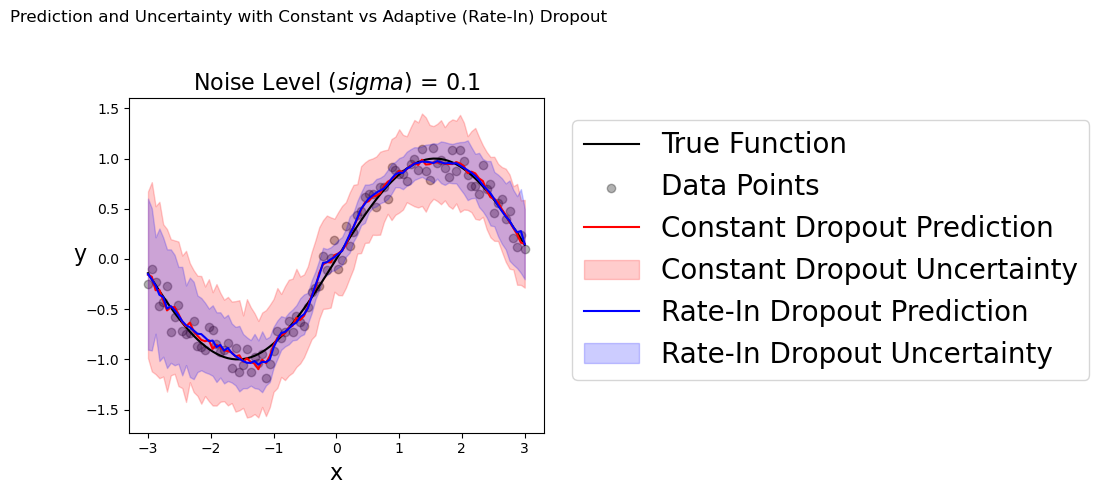

In [14]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()

ax.plot(x_test, y_test, 'k', label = "True Function")
ax.scatter(x_train, y_train, color='k', alpha=0.3, label = "Data Points")

approach = 'Constant'
ax.plot(x_test, PREDs[approach].squeeze(), 'r', label = "Constant Dropout Prediction")
ax.fill_between(x_test, (PREDs[approach] - 2 * STDs[approach]).squeeze(), (PREDs[approach] + 2 * STDs[approach]).squeeze(), color='red', alpha = 0.2, label = "Constant Dropout Uncertainty")

approach = 'Rate-In'
ax.plot(x_test, PREDs[approach].squeeze(), 'b', label = "Rate-In Dropout Prediction")
ax.fill_between(x_test, (PREDs[approach] - 2 * STDs[approach]).squeeze(), (PREDs[approach] + 2 * STDs[approach]).squeeze(), color='blue', alpha = 0.2, label = "Rate-In Dropout Uncertainty")

ax.set_title(f"Noise Level ($sigma$) = {noise_level}", fontsize = 16)
ax.set_xlabel("x", fontsize = 16)
ax.set_ylabel("y", fontsize = 16, rotation=0)

plt.suptitle("Prediction and Uncertainty with Constant vs Adaptive (Rate-In) Dropout")

# Add a single legend to the right of the figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor = (1, 0.5), fontsize = 20)
plt.tight_layout(rect = [0, 0, 1, 0.95])

plt.show()
